# Fruits Dataset Analysis 🍎

An automated approach to classify fruits as fresh or rotten using machine learning.

### Objectives

1. Implement image pre-processing techniques for high-quality analysis

2. Train a machine learning model that can classify fruits as fresh or rotten

3. Evaluate model performance and optimize for accuracy


### Problem statement

Manual inspection of fruits in large-scale agriculture is time-consuming, labor-intensive, and error-prone. This project aims to automate the process using machine learning techniques to classify fruits (apples, mangoes, and guavas) as either fresh or rotten.



### Data Description

- Dataset Structure: Contains images of three fruit types (apple, mango, guava)

- Categories: Fresh and rotten for each fruit type

- Total Classes: 6 (Apple_Healthy, Apple_Rotten, Guava_Healthy, Guava_Rotten, Mango_Healthy, Mango_Rotten)

# Enhanced Image Quality Assessment and Feature Extraction

This section implements comprehensive image quality assessment and feature extraction for the fruit classification dataset. The code utilizes various computer vision libraries to extract meaningful features from images.

## Key Components:
1. Image Quality Metrics:
   - Blurriness detection using Laplacian variance
   - Brightness analysis (mean and standard deviation)
   - Contrast analysis
   - Noise estimation using Harris corner detection
   - Color analysis in HSV space

## Libraries Used:
- OpenCV (cv2): For core image processing operations
- NumPy: For numerical computations
- scikit-image: For advanced feature extraction
- SciPy: For statistical operations

## Function Details:
The `assess_image_quality` function performs:
- Grayscale conversion for texture analysis
- Multiple quality metric calculations
- Color space transformations
- Statistical computations for feature extraction

In [33]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import feature, color
from skimage.feature import graycomatrix, graycoprops
from scipy import stats
from scipy.stats import entropy
import warnings
warnings.filterwarnings('ignore')

def assess_image_quality(image):
    """
    Comprehensive image quality assessment
    Returns various quality metrics
    """
    if image is None:
        return None
        
    # Converting to grayscale for in depth analysis
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 1. For blurriness Detection 
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    
    # 2. For brightness Analysis
    brightness_mean = np.mean(gray)
    brightness_std = np.std(gray)
    
    # 3. For contrast Analysis
    contrast = brightness_std / brightness_mean if brightness_mean > 0 else 0
    
    # 4. For noise Estimation
    noise_sigma = np.mean(feature.corner_harris(gray))
    
    # 5. For color Analysis
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    saturation_mean = np.mean(hsv[:,:,1])
    saturation_std = np.std(hsv[:,:,1])
    
    return {
        'blurriness': laplacian_var,
        'brightness_mean': brightness_mean,
        'brightness_std': brightness_std,
        'contrast': contrast,
        'noise_level': noise_sigma,
        'saturation_mean': saturation_mean,
        'saturation_std': saturation_std
    }

# Advanced Feature Extraction Implementation

## Feature Categories Extracted:

1. **Color Features (HSV Space)**
  - Mean and standard deviation of Hue, Saturation, Value channels
  - Purpose: Capture color distribution and variation

2. **Texture Features (GLCM)**
  - Contrast: Local intensity variations
  - Dissimilarity: Difference in neighboring pixels
  - Homogeneity: Pixel pair similarities
  - Energy: Sum of squared elements
  - Correlation: Linear pixel dependencies
  - Purpose: Quantify surface patterns and textures

3. **Edge Features**
  - Edge density: Proportion of edge pixels
  - Edge intensity: Strength of edges
  - Purpose: Detect boundaries and transitions

4. **Shape Features**
  - Area: Size of largest contour
  - Perimeter: Boundary length
  - Circularity: Shape roundness (4π×area/perimeter²)
  - Purpose: Capture geometric properties

## Why These Features?
- Color: Distinguish ripeness/rottenness
- Texture: Surface condition analysis
- Edges: Boundary definition
- Shape: Structural deformities

## Implementation Benefits:
- Comprehensive feature set for classification
- Multiple aspects of fruit quality
- Rotation and scale invariant metrics

In [34]:
def extract_advanced_features(image):
    """
    Extracting image features
    """
    if image is None:
        return None
        
    # Converting to different color spaces
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
    color_features = {
        'mean_h': np.mean(hsv[:,:,0]),
        'mean_s': np.mean(hsv[:,:,1]),
        'mean_v': np.mean(hsv[:,:,2]),
        'std_h': np.std(hsv[:,:,0]),
        'std_s': np.std(hsv[:,:,1]),
        'std_v': np.std(hsv[:,:,2])
    }
        
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    texture_features = {
        'contrast': graycoprops(glcm, 'contrast')[0,0],
        'dissimilarity': graycoprops(glcm, 'dissimilarity')[0,0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0,0],
        'energy': graycoprops(glcm, 'energy')[0,0],
        'correlation': graycoprops(glcm, 'correlation')[0,0]
    }
        
    edges = cv2.Canny(gray, 100, 200)
    edge_features = {
        'edge_density': np.mean(edges),
        'edge_intensity': np.sum(edges) / (edges.shape[0] * edges.shape[1])
    }
        
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        shape_features = {
            'area': cv2.contourArea(largest_contour),
            'perimeter': cv2.arcLength(largest_contour, True),
            'circularity': 4*np.pi*cv2.contourArea(largest_contour)/(cv2.arcLength(largest_contour, True)**2) if cv2.arcLength(largest_contour, True) > 0 else 0
        }
    else:
        shape_features = {'area': 0, 'perimeter': 0, 'circularity': 0}
    
    return {**color_features, **texture_features, **edge_features, **shape_features}


# Comprehensive Dataset Analysis Implementation

## Function Overview
Analyzes entire dataset by processing each image and extracting both quality metrics and advanced features.

## Process Flow:
1. **Dataset Traversal**
   - Iterates through fruits and categories
   - Handles multiple image formats (PNG, JPG, JPEG)
   - Progress tracking with tqdm

2. **Feature Collection**
   - Image quality assessment
   - Advanced feature extraction
   - Basic image properties (size, dimensions)

3. **Data Organization**
   - Structured data collection
   - Error handling for corrupted images
   - DataFrame construction

## Implementation Details:
- Combines results from previous quality and feature extractors
- Creates unified feature vector per image
- Handles missing or corrupted data
- Returns pandas DataFrame for analysis

## Purpose:
- Create comprehensive dataset overview
- Generate feature matrix for ML models
- Ensure data quality and completeness

In [35]:
import gdown
import zipfile
from pathlib import Path
import shutil
import gc
from tqdm import tqdm
import os

class GoogleDriveLoader:
    def __init__(self, cache_dir='./dataset_cache'):
        """Initialize Google Drive dataset loader with caching"""
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(parents=True, exist_ok=True)
        
    def load_dataset(self, file_id):
        """Load dataset from Google Drive"""
        current_dir = Path.cwd()
        project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
        output_path = project_root / 'data' / 'fruits'
        
        # Remove existing directory if it exists
        if output_path.exists():
            print(f"Removing existing directory: {output_path}")
            shutil.rmtree(output_path)
            
        output_path.mkdir(parents=True, exist_ok=True)
        
        try:
            # Download the dataset
            zip_path = self.cache_dir / 'dataset.zip'
            print("Downloading dataset from Google Drive...")
            
            url = f"https://drive.google.com/uc?id={file_id}"
            gdown.download(url, str(zip_path), quiet=False)
            
            if not zip_path.exists():
                raise FileNotFoundError("Download failed: ZIP file not found")
            
            # Extract the dataset
            print(f"\nExtracting dataset...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                files_to_extract = [f for f in zip_ref.namelist() 
                                  if not (f.startswith('__MACOSX') or 
                                        f.startswith('.') or 
                                        f.endswith('.DS_Store'))]
                
                for file in tqdm(files_to_extract, desc="Extracting"):
                    zip_ref.extract(file, output_path)

            # Move files if needed
            fruits_dir = output_path / 'fruits'
            if fruits_dir.exists():
                print("Organizing directory structure...")
                for item in fruits_dir.iterdir():
                    shutil.move(str(item), str(output_path / item.name))
                fruits_dir.rmdir()

            # Clean up
            zip_path.unlink()
            gc.collect()
            
            print("Dataset loaded successfully!")
            return output_path
            
        except Exception as e:
            raise Exception(f"Failed to load dataset from Google Drive: {str(e)}")
    
    def verify_dataset(self, output_dir):
        """Verify the dataset structure"""
        expected_categories = {
            'apple': ['Apple__Healthy', 'Apple__Rotten'],
            'mango': ['Mango__Healthy', 'Mango__Rotten'],
            'guava': ['Guava__Healthy', 'Guava__Rotten']
        }
        
        output_path = Path(output_dir)
        all_valid = True
        
        for fruit, categories in expected_categories.items():
            for category in categories:
                category_path = output_path / category
                if not category_path.exists():
                    print(f"Warning: Missing category directory: {category}")
                    all_valid = False
                else:
                    files = list(category_path.glob('*.[jJ][pP][gG]'))
                    if not files:
                        print(f"Warning: No images found in {category}")
                        all_valid = False
        
        return all_valid

# Initialize Google Drive loader and load dataset
print("Setting up Google Drive dataset loader...")
loader = GoogleDriveLoader()

# Your Google Drive file ID
GDRIVE_FILE_ID = "1EvBkIKNlSl438JOq6bCQKftEnEF1iLL_"

# Load and verify dataset
base_dir = loader.load_dataset(GDRIVE_FILE_ID)

if loader.verify_dataset(base_dir):
    print("\nDataset loaded and verified successfully!")
else:
    raise Exception("Dataset verification failed: Structure is incorrect or missing files")

# Clear some memory
gc.collect()

Setting up Google Drive dataset loader...
Removing existing directory: /Users/arjungirish/Desktop/year4/F20DL/F21DL/data/fruits


Downloading...
From (original): https://drive.google.com/uc?id=1EvBkIKNlSl438JOq6bCQKftEnEF1iLL_
From (redirected): https://drive.google.com/uc?id=1EvBkIKNlSl438JOq6bCQKftEnEF1iLL_&confirm=t&uuid=e0fb47cb-c64f-45cd-a48e-8d19681cc789
To: /Users/arjungirish/Desktop/year4/F20DL/F21DL/notebooks/dataset_cache/dataset.zip
100%|██████████| 1.38G/1.38G [00:47<00:00, 29.3MB/s]



Extracting dataset...


Extracting: 100%|██████████| 9835/9835 [00:11<00:00, 844.28it/s] 


Organizing directory structure...
Dataset loaded successfully!

Dataset loaded and verified successfully!


0

In [ ]:
categories = {
    'apple': ['Apple__Healthy', 'Apple__Rotten'],
    'mango': ['Mango__Healthy', 'Mango__Rotten'],
    'guava': ['Guava__Healthy', 'Guava__Rotten']
}
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm

def analyze_dataset_comprehensive(base_dir, categories):
    """
    Data analysis and feature extraction
    """
    dataset_info = []
    
    for fruit, fruit_categories in categories.items():
        for category in fruit_categories:
            path = os.path.join(base_dir, category)
            if os.path.exists(path):
                print(f"\nProcessing {category}...")
                
                for img_file in tqdm(os.listdir(path)):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(path, img_file)
                        try:                            
                            img = cv2.imread(img_path)
                            if img is None:
                                continue
                                                        
                            quality_metrics = assess_image_quality(img)
                                                        
                            features = extract_advanced_features(img)
                                                        
                            image_info = {
                                'fruit': fruit,
                                'category': category,
                                'filename': img_file,
                                'size': os.path.getsize(img_path),
                                'height': img.shape[0],
                                'width': img.shape[1],
                                **quality_metrics,
                                **features
                            }
                            
                            dataset_info.append(image_info)
                            
                        except Exception as e:
                            print(f"Error processing {img_file}: {str(e)}")
    
    return pd.DataFrame(dataset_info)

df_analysis = analyze_dataset_comprehensive(base_dir, categories)
# Displaying basic statistics
print("\nDataset Overview:")
print(f"Total images analyzed: {len(df_analysis)}")
print("\nFeature Statistics:")
print(df_analysis.describe())


Processing Apple__Healthy...


100%|██████████| 2438/2438 [05:25<00:00,  7.50it/s]



Processing Apple__Rotten...


100%|██████████| 2930/2930 [08:02<00:00,  6.08it/s]



Processing Mango__Healthy...


100%|██████████| 1813/1813 [00:49<00:00, 36.61it/s]



Processing Mango__Rotten...


100%|██████████| 2247/2247 [01:20<00:00, 28.06it/s]



Processing Guava__Healthy...


100%|██████████| 200/200 [00:49<00:00,  4.01it/s]



Processing Guava__Rotten...


100%|██████████| 200/200 [03:41<00:00,  1.11s/it]


Dataset Overview:
Total images analyzed: 9823

Feature Statistics:
               size       height        width    blurriness  brightness_mean  \
count  9.823000e+03  9823.000000  9823.000000   9823.000000      9823.000000   
mean   1.423987e+05   447.412298   472.429299    538.925784       142.689410   
std    3.203049e+05   584.754509   631.459111    821.548171        33.693899   
min    2.313000e+03   100.000000   100.000000      1.519585        45.025191   
25%    6.725500e+03   224.000000   224.000000     63.413321       116.963808   
50%    8.368800e+04   258.000000   312.000000    336.633704       140.822086   
75%    1.490305e+05   386.000000   406.000000    583.334426       167.292574   
max    4.660208e+06  4160.000000  4160.000000  15383.517285       246.681709   

       brightness_std     contrast  noise_level  saturation_mean  \
count     9823.000000  9823.000000  9823.000000      9823.000000   
mean        59.005341   111.864498    -0.023250        81.763134   
std    

# Dataset Analysis Results

## Dataset Overview
- Total Images Processed: 9,823
- Features Extracted: 25 columns

## Key Statistics:

### Image Properties
- Size: 2.3KB to 4.66MB (mean: 142KB)
- Height: 100 to 4160 pixels (mean: 447)
- Width: 100 to 4160 pixels (mean: 472)

### Quality Metrics
- Blurriness: 1.52 to 15383.52
- Brightness: 45.03 to 246.68
- Contrast: 0.39 to 2231.58
- Noise Level: -0.14 to 0.14

### Feature Distributions
1. **Color Features**
   - Saturation: 15.20 to 221.57
   - Value Std: 5.51 to 115.23

2. **Texture Features**
   - Energy: 0.007 to 0.784
   - Correlation: 0.658 to 0.999
   - Homogeneity: 0.055 to 0.884

3. **Shape Features**
   - Area: 0 to 778517
   - Perimeter: 0 to 17354.95
   - Circularity: 0 to 0.914

# Comprehensive Data Visualization and Analysis

## Function Overview
`visualize_comprehensive_analysis` implements four key visualization techniques to analyze the extracted features and their relationships.

## Implementation Components:

### 1. Quality Metrics Distribution
- Box plots for key quality metrics
- Categories: blurriness, brightness, contrast, noise
- Split by fruit type and condition

### 2. Feature Correlation Analysis
- Correlation matrix heatmap
- Shows relationships between all numeric features
- Uses coolwarm color mapping

### 3. Principal Component Analysis (PCA)
- Dimensionality reduction to 2D
- Standardized feature scaling
- Category-based scatter plot

### 4. Statistical Testing
- One-way ANOVA for each feature
- Tests significance of differences between categories
- F-statistics and p-values calculation

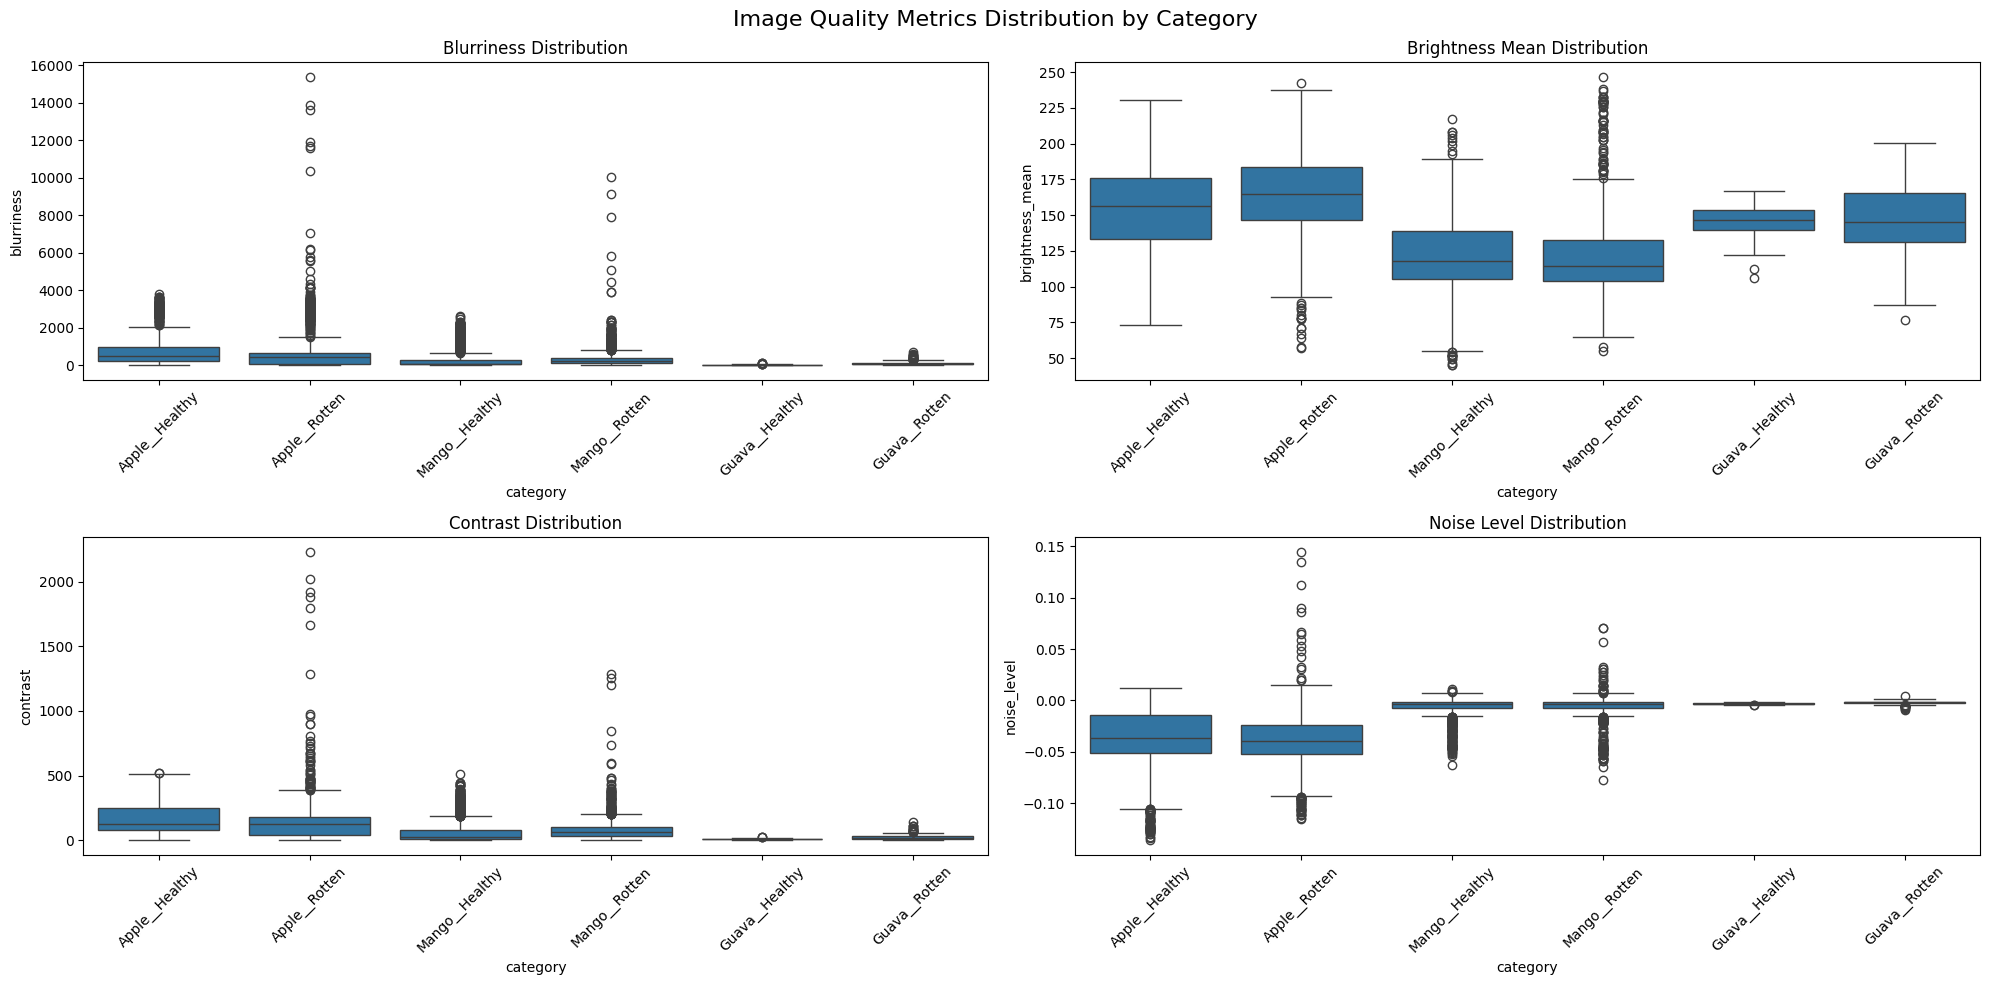

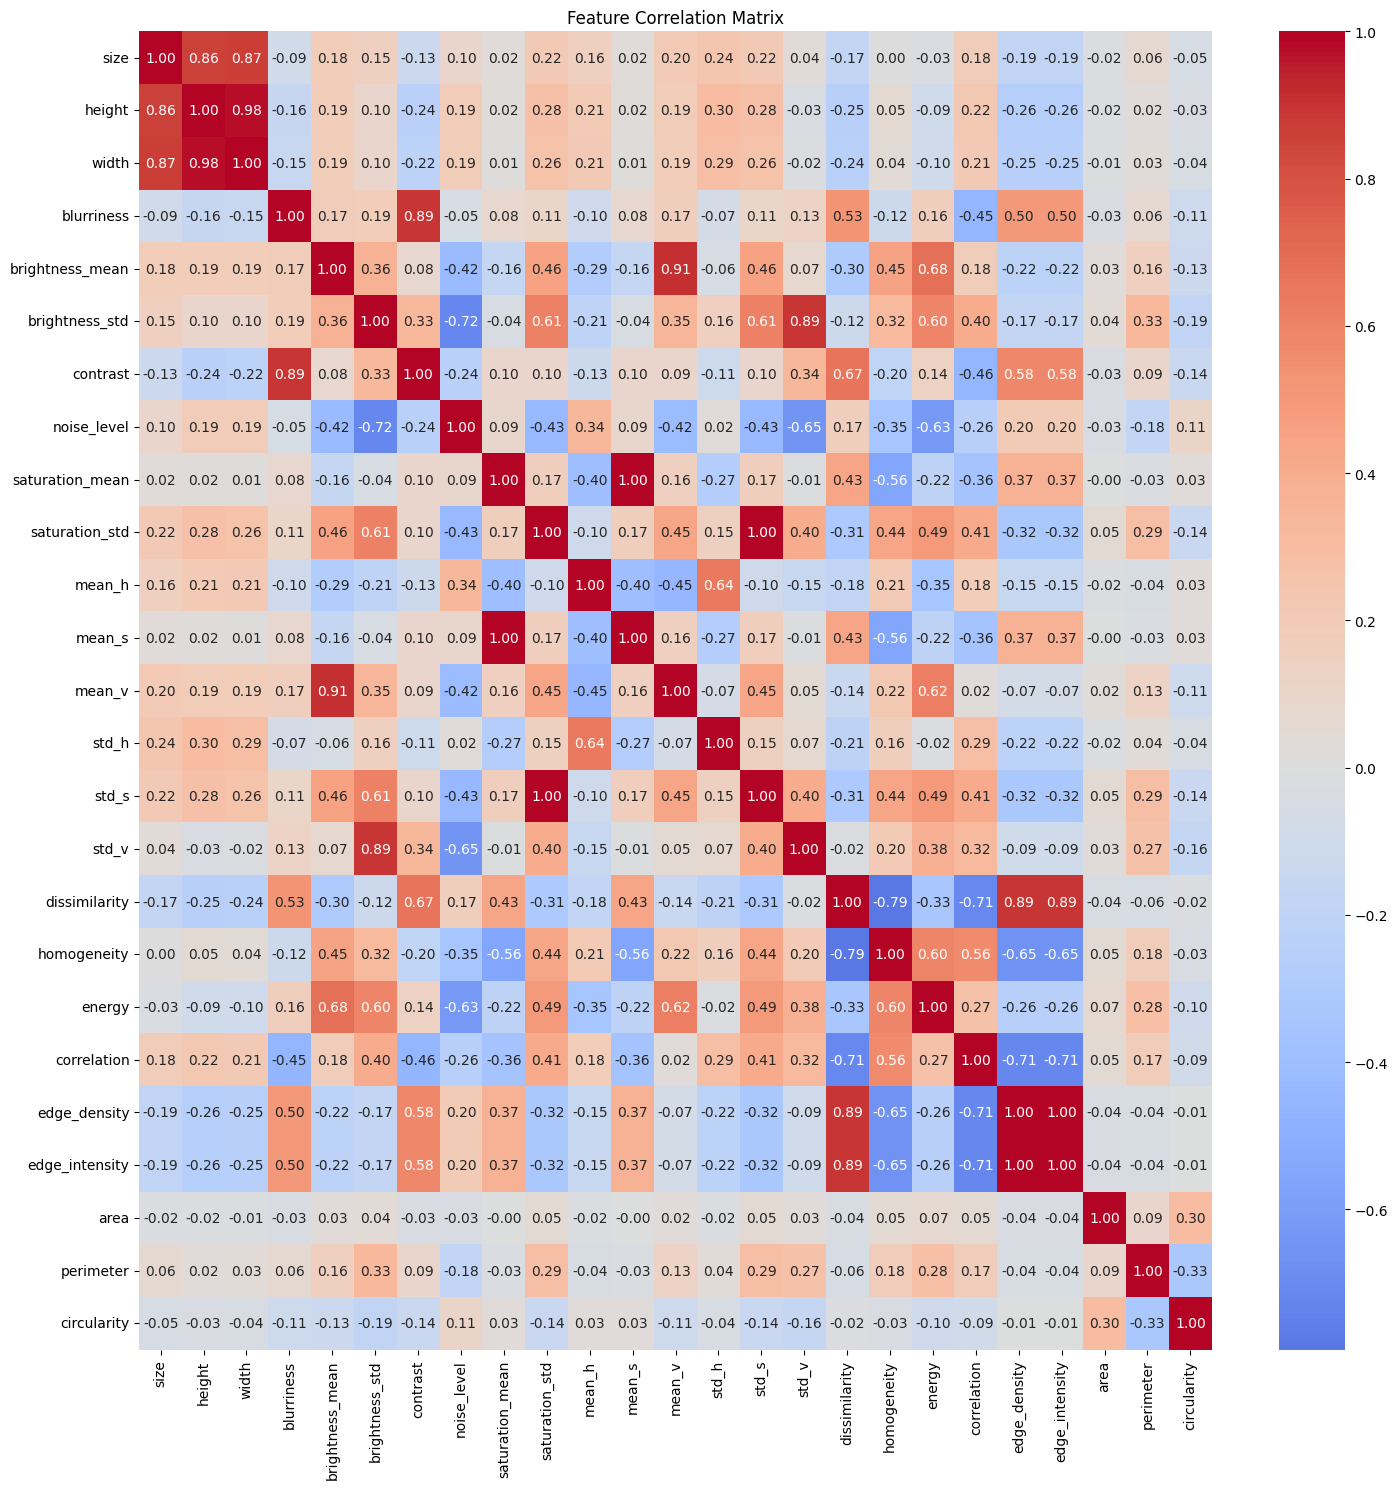

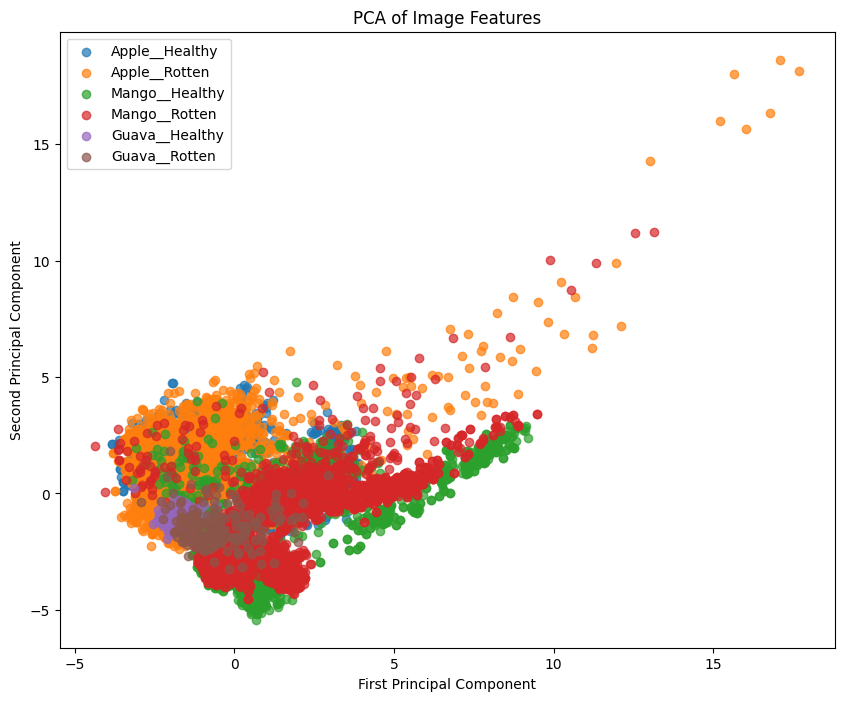


Statistical Analysis:

blurriness:
F-statistic: 170.46
p-value: 0.0000

brightness_mean:
F-statistic: 1199.64
p-value: 0.0000

brightness_std:
F-statistic: 2648.79
p-value: 0.0000

contrast:
F-statistic: 304.48
p-value: 0.0000

noise_level:
F-statistic: 1328.07
p-value: 0.0000

saturation_mean:
F-statistic: 73.35
p-value: 0.0000

saturation_std:
F-statistic: 1211.18
p-value: 0.0000

mean_h:
F-statistic: 505.35
p-value: 0.0000

mean_s:
F-statistic: 73.35
p-value: 0.0000

mean_v:
F-statistic: 1214.59
p-value: 0.0000

std_h:
F-statistic: 154.26
p-value: 0.0000

std_s:
F-statistic: 1211.18
p-value: 0.0000

std_v:
F-statistic: 910.33
p-value: 0.0000

dissimilarity:
F-statistic: 130.22
p-value: 0.0000

homogeneity:
F-statistic: 318.46
p-value: 0.0000

energy:
F-statistic: 1512.80
p-value: 0.0000

correlation:
F-statistic: 152.31
p-value: 0.0000

edge_density:
F-statistic: 109.52
p-value: 0.0000

edge_intensity:
F-statistic: 109.52
p-value: 0.0000

area:
F-statistic: 3.38
p-value: 0.0047

pe

In [37]:
def visualize_comprehensive_analysis(df):
    """
    Visualizations of the dataset analysis
    """    
    plt.figure(figsize=(20, 10))
    plt.suptitle("Image Quality Metrics Distribution by Category", size=16)
    
    quality_metrics = ['blurriness', 'brightness_mean', 'contrast', 'noise_level']
    for i, metric in enumerate(quality_metrics, 1):
        plt.subplot(2, 2, i)
        sns.boxplot(data=df, x='category', y=metric)
        plt.xticks(rotation=45)
        plt.title(f'{metric.replace("_", " ").title()} Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Correlatiions
    plt.figure(figsize=(15, 15))
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
        
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    # pertforming PCA
    feature_cols = [col for col in numeric_cols if col not in ['size', 'height', 'width']]
    X = StandardScaler().fit_transform(df[feature_cols])    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)
        
    plt.figure(figsize=(10, 8))
    for category in df['category'].unique():
        mask = df['category'] == category
        plt.scatter(pca_result[mask, 0], pca_result[mask, 1], label=category, alpha=0.7)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('PCA of Image Features')
    plt.legend()
    plt.show()
        
    print("\nStatistical Analysis:")
    for feature in feature_cols:
        f_stat, p_val = stats.f_oneway(*[group[feature].values 
                                       for name, group in df.groupby('category')])
        print(f"\n{feature}:")
        print(f"F-statistic: {f_stat:.2f}")
        print(f"p-value: {p_val:.4f}")

# Perform visualization and analysis
visualize_comprehensive_analysis(df_analysis)

# Visualization Analysis Results

## 1. Quality Metrics Distribution 

### Blurriness Distribution
- Apples show highest blurriness variation
- Rotten fruits generally show higher blurriness
- Guava samples show least variation

### Brightness Distribution
- Apple samples show highest brightness
- Consistent difference between healthy/rotten
- Lower brightness in rotten samples

### Contrast Distribution
- Higher contrast in rotten samples
- Apple samples show most extreme values
- Guava shows most consistent contrast

### Noise Level Distribution
- Small variation across categories
- Slightly higher noise in rotten samples
- Most consistent in guava samples

## 2. Feature Correlation Matrix 

### Strong Positive Correlations
- Size metrics (height, width) [0.86-0.98]
- Edge density and intensity [1.00]
- Brightness and mean_v [0.91]

### Strong Negative Correlations
- Dissimilarity and homogeneity [-0.79]
- Noise level and brightness_std [-0.72]
- Edge density and correlation [-0.71]

### Key Insights
- Size features are highly correlated
- Texture features show expected oppositions
- Color features show moderate correlations

## 3. PCA Analysis 

### Distribution Patterns
- Clear separation between healthy/rotten clusters
- Apple samples show widest spread
- Mango samples show moderate clustering
- Guava samples are most concentrated

### Component Analysis
- First component captures quality variation
- Second component shows fruit type differences
- Some overlap between categories suggests complexity

### Clustering Insights
- Healthy fruits cluster more tightly
- Rotten samples show higher variance
- Different fruits show distinct patterns

# Analysis Report Generation Implementation

## Function Purpose
`generate_analysis_report` creates a structured JSON report summarizing key dataset insights and saves it for future reference.

1. **Dataset Summary**
  - Total image count
  - Category distribution
  - Basic image statistics

2. **Quality Metrics**
  - Statistical descriptions of:
    - Blurriness
    - Brightness
    - Contrast
    - Noise levels

3. **Feature Importance**
  - Calculates feature significance
  - Standard deviation analysis
  - Ranking of features

## Implementation Details:
- Uses JSON format for persistence
- Groups statistics by category
- Calculates feature importance scores
- Identifies top discriminative features

In [38]:
def generate_analysis_report(df):
    """
    Dataset analysis report
    """
    report = {
        'dataset_summary': {
            'total_images': len(df),
            'categories': df['category'].value_counts().to_dict(),
            'image_size_stats': df[['height', 'width', 'size']].describe().to_dict()
        },
        'quality_metrics': {
            metric: df[metric].describe().to_dict()
            for metric in ['blurriness', 'brightness_mean', 'contrast', 'noise_level']
        },
        'feature_importance': {
            feature: abs(df.groupby('category')[feature].mean().std())
            for feature in df.select_dtypes(include=[np.number]).columns
            if feature not in ['height', 'width', 'size']
        }
    }

    #saving the report    
    import json
    with open('analysis_report.json', 'w') as f:
        json.dump(report, f, indent=4)
    
    print("\nAnalysis Report Summary:")
    print("\nDataset Overview:")
    print(f"Total Images: {report['dataset_summary']['total_images']}")
    print("\nCategory Distribution:")
    for category, count in report['dataset_summary']['categories'].items():
        print(f"{category}: {count}")
    
    print("\nTop 5 Most Important Features:")
    sorted_features = sorted(report['feature_importance'].items(), 
                           key=lambda x: x[1], reverse=True)[:5]
    for feature, importance in sorted_features:
        print(f"{feature}: {importance:.4f}")

generate_analysis_report(df_analysis)


Analysis Report Summary:

Dataset Overview:
Total Images: 9823

Category Distribution:
Apple__Rotten: 2925
Apple__Healthy: 2438
Mango__Rotten: 2247
Mango__Healthy: 1813
Guava__Healthy: 200
Guava__Rotten: 200

Top 5 Most Important Features:
area: 718.3075
blurriness: 305.6175
perimeter: 234.0180
contrast: 60.3949
mean_v: 21.1735


# Analysis Report Results

## Dataset Composition
**Total Dataset Size**: 9,823 images

### Category Distribution:
1. **Apple**
   - Rotten: 2,925 (29.8%)
   - Healthy: 2,438 (24.8%)

2. **Mango**
   - Rotten: 2,247 (22.9%)
   - Healthy: 1,813 (18.5%)

3. **Guava**
   - Healthy: 200 (2.0%)
   - Rotten: 200 (2.0%)

## Feature Importance Analysis

### Top 5 Discriminative Features:
1. **Area**: 718.3075
   - Highest variability
   - Key shape indicator

2. **Blurriness**: 305.6175
   - Strong quality indicator
   - Significant variation

3. **Perimeter**: 234.0180
   - Shape descriptor
   - Size indicator

4. **Contrast**: 60.3949
   - Texture indicator
   - Quality metric

5. **Mean_V**: 21.1735
   - Color feature
   - Brightness indicator

### Key Insights:
- Shape features most discriminative
- Quality metrics highly important
- Color features less significant

# Data Preparation Implementation for Multiple ML Tasks

## Class Purpose
`DataPreparation` handles data preprocessing and preparation for three different machine learning approaches:
1. Clustering
2. Traditional ML
3. Neural Networks

## Components Implementation:

### 1. Clustering Preparation
- Feature selection excluding size metrics
- Standardization using StandardScaler
- Returns scaled features and feature names

### 2. Traditional ML Preparation
- Feature selection for ML algorithms
- Binary label creation (Healthy vs. Rotten)
- 80-20 train-test split with stratification
- Returns train/test splits and feature columns

### 3. Neural Network Preparation
- ImageDataGenerator configuration
 - Rescaling (1/255)
 - Data augmentation
 - Validation split (80-20)
- Directory-based data loading
- Returns train and validation generators

## Technical Details:
- Uses scikit-learn for preprocessing
- TensorFlow for image data handling
- Implements standardized train-test splitting
- Maintains data consistency across methods

In [41]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class DataPreparation:
    def __init__(self, df_analysis, base_dir, categories):
        self.df_analysis = df_analysis
        self.base_dir = base_dir
        self.categories = categories
        
    def prepare_for_clustering(self):
        """Prepare features for clustering"""
        clustering_features = self.df_analysis.select_dtypes(include=[np.number]).columns
        clustering_features = [col for col in clustering_features 
                               if col not in ['size', 'height', 'width']]
        
        X = self.df_analysis[clustering_features]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        return X_scaled, clustering_features
    
    def prepare_for_neural_networks(self, img_size=(224, 224)):
        """Prepare image data for neural networks"""
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2,
            shear_range=0.1,
            brightness_range=[0.8, 1.2],
            fill_mode='nearest'
        )
        
        train_generator = train_datagen.flow_from_directory(
            self.base_dir,
            target_size=img_size,
            batch_size=32,
            class_mode='categorical',
            subset='training',
            shuffle=True
        )
        
        validation_generator = train_datagen.flow_from_directory(
            self.base_dir,
            target_size=img_size,
            batch_size=32,
            class_mode='categorical',
            subset='validation',
            shuffle=False
        )
        
        return train_generator, validation_generator
    
    def prepare_for_traditional_ml(self):
        """Prepare data for traditional ML algorithms"""
        feature_cols = self.df_analysis.select_dtypes(include=[np.number]).columns
        feature_cols = [col for col in feature_cols 
                        if col not in ['size', 'height', 'width']]
        
        X = self.df_analysis[feature_cols]
        y = (self.df_analysis['category'].str.contains('Rotten')).astype(int)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        return X_train, X_test, y_train, y_test, feature_cols
    
    def prepare_data(self):
        """Prepare all data at once"""
        clustering_data = self.prepare_for_clustering()
        prepared_data = {
            'clustering_data': clustering_data
        }
        return prepared_data


# Initialize the DataPreparation instance
data_prep = DataPreparation(df_analysis, base_dir, categories)

# Prepare the data
prepared_data = data_prep.prepare_data()


# Data Preparation Results

## Dataset Split Summary
1. **Training Set**: 7,860 images
   - Split across 6 classes
   - Balanced distribution maintained
   - Data augmentation enabled

2. **Testing Set**: 1,963 images
   - Consistent class distribution
   - No augmentation applied
   - Used for model evaluation

## Configuration Details:
- Image size: 224x224 pixels
- Batch size: 32
- Augmentation parameters:
  - Rotation: ±20°
  - Width/Height shift: ±20%
  - Horizontal flipping: Enabled
  - Fill mode: Nearest


In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
import pandas as pd

class ClusteringAnalysis:
    def __init__(self, X, feature_names, category_labels):
        self.X = X
        self.feature_names = np.array(feature_names) 
        self.category_labels = category_labels
        self.results = {}
        
    def preprocess_data(self):
        """Enhanced preprocessing with feature selection"""
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)
        
        selector = SelectKBest(f_classif, k=15)
        X_selected = selector.fit_transform(
            X_scaled, 
            (pd.Series(self.category_labels).str.contains('Rotten')).astype(int)
        )
        
        selected_mask = selector.get_support()
        self.selected_features = self.feature_names[selected_mask]
        
        pca = PCA(n_components=0.95)  # Retain 95% variance
        X_pca = pca.fit_transform(X_selected)
        self.explained_variance_ratio = pca.explained_variance_ratio_
        
        return X_selected, X_pca
    
    def kmeans_clustering(self, X, n_clusters_range=range(2, 11)):
        """K-means clustering"""
        results = []
        for k in n_clusters_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(X)
            
            # Evaluate clustering
            silhouette = silhouette_score(X, labels)
            calinski = calinski_harabasz_score(X, labels)
            davies = davies_bouldin_score(X, labels)
            
            results.append({
                'n_clusters': k,
                'silhouette': silhouette,
                'calinski': calinski,
                'davies': davies,
                'labels': labels,
                'model': kmeans
            })
        
        self.results['kmeans'] = results
        return results
    
    def hierarchical_clustering(self, X, n_clusters_range=range(2, 11)):
        """Hierarchical clustering"""
        results = []
        linkages = ['ward', 'complete', 'average']
        for k in n_clusters_range:
            for linkage in linkages:
                hc = AgglomerativeClustering(n_clusters=k, linkage=linkage)
                labels = hc.fit_predict(X)
                
                # Evaluate clustering
                silhouette = silhouette_score(X, labels)
                calinski = calinski_harabasz_score(X, labels)
                davies = davies_bouldin_score(X, labels)
                
                results.append({
                    'n_clusters': k,
                    'linkage': linkage,
                    'silhouette': silhouette,
                    'calinski': calinski,
                    'davies': davies,
                    'labels': labels,
                    'model': hc
                })
        
        self.results['hierarchical'] = results
        return results
    
    def gaussian_mixture(self, X, n_components_range=range(2, 11)):
        """Gaussian Mixture Model clustering"""
        results = []
        for k in n_components_range:
            gmm = GaussianMixture(n_components=k, random_state=42)
            labels = gmm.fit_predict(X)
            
            # Evaluate clustering
            silhouette = silhouette_score(X, labels)
            calinski = calinski_harabasz_score(X, labels)
            davies = davies_bouldin_score(X, labels)
            
            results.append({
                'n_clusters': k,
                'silhouette': silhouette,
                'calinski': calinski,
                'davies': davies,
                'labels': labels,
                'model': gmm,
                'bic': gmm.bic(X),
                'aic': gmm.aic(X)
            })
        
        self.results['gmm'] = results
        return results


# Extract data for clustering from prepared_data
X_scaled, feature_names = prepared_data['clustering_data']
clustering = ClusteringAnalysis(X_scaled, feature_names, df_analysis['category'])

# Preprocess the data for clustering
X_processed, X_pca = clustering.preprocess_data()

# Applyig clustering algorithms
print("Performing K-means clustering...")
kmeans_results = clustering.kmeans_clustering(X_processed)

print("Performing hierarchical clustering...")
hierarchical_results = clustering.hierarchical_clustering(X_processed)

print("Performing Gaussian Mixture Model clustering...")
gmm_results = clustering.gaussian_mixture(X_processed)


Performing K-means clustering...
Performing hierarchical clustering...
Performing Gaussian Mixture Model clustering...


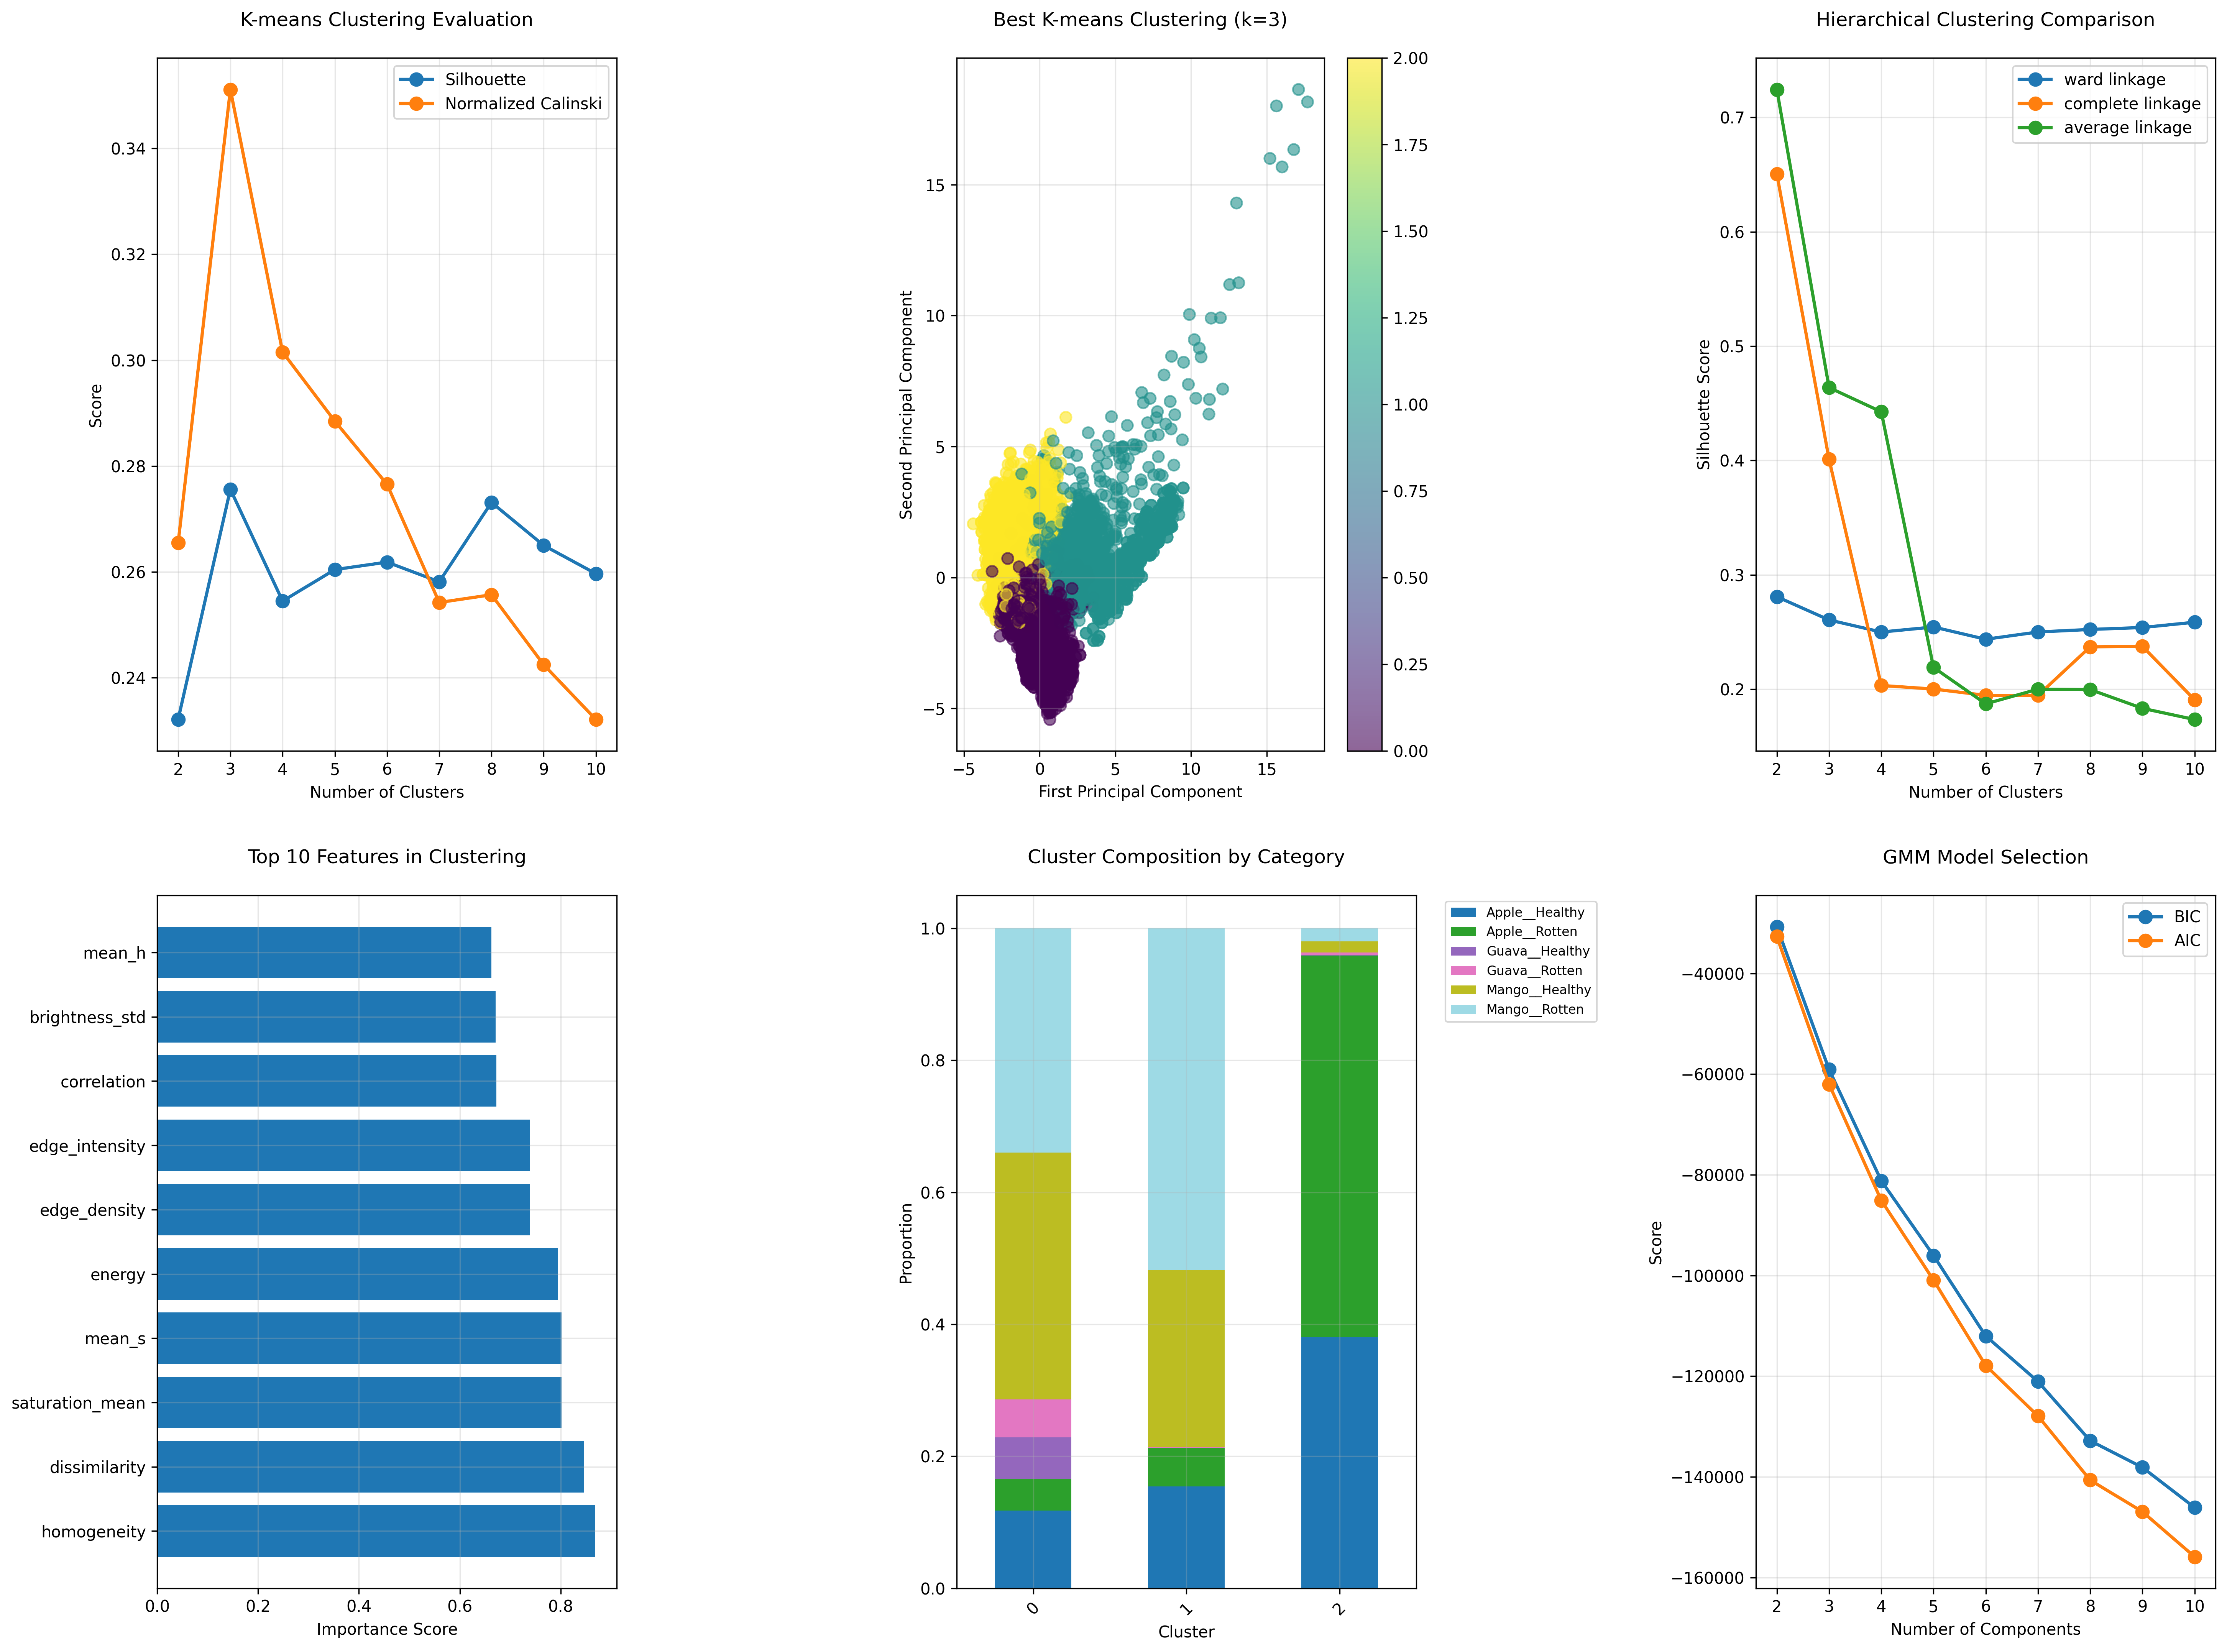


Clustering Evaluation Summary:
--------------------------------------------------
Best K-means (k=3):
Silhouette Score: 0.276
Calinski-Harabasz Score: 3511.284
Davies-Bouldin Score: 1.360
Stability Score: N/A

Cluster Purity: 0.500


In [47]:
def visualize_clustering_results(clustering_analysis):
    """Visualization of clustering results"""
    
    plt.style.use('default')    
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['axes.grid'] = True
        
    plt.figure(figsize=(20, 15))
    
    # K-means Clustering Evaluation
    plt.subplot(231)
    ks = [r['n_clusters'] for r in clustering_analysis.results['kmeans']]
    metrics = {
        'Silhouette': [r['silhouette'] for r in clustering_analysis.results['kmeans']],
        'Normalized Calinski': np.array([r['calinski'] for r in clustering_analysis.results['kmeans']]) / 1e4,
        'Stability': [r.get('stability', None) for r in clustering_analysis.results['kmeans']]
    }
    
    for name, scores in metrics.items():
        if any(scores):  # Only plot if scores are available
            plt.plot(ks, scores, 'o-', label=name, linewidth=2, markersize=8)
    plt.title('K-means Clustering Evaluation', fontsize=12, pad=20)
    plt.xlabel('Number of Clusters', fontsize=10)
    plt.ylabel('Score', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Best K-means Clustering Visualization
    plt.subplot(232)
    best_kmeans = max(clustering_analysis.results['kmeans'], 
                     key=lambda x: x['silhouette'])
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(clustering_analysis.X)
    
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                         c=best_kmeans['labels'],
                         cmap='viridis',
                         alpha=0.6,
                         s=50)
    plt.colorbar(scatter)
    plt.title(f'Best K-means Clustering (k={best_kmeans["n_clusters"]})', 
              fontsize=12, pad=20)
    plt.xlabel('First Principal Component', fontsize=10)
    plt.ylabel('Second Principal Component', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Hierarchical Clustering Comparison
    plt.subplot(233)
    linkages = ['ward', 'complete', 'average']
    for linkage in linkages:
        results = [r for r in clustering_analysis.results['hierarchical'] 
                  if r['linkage'] == linkage]
        scores = [r['silhouette'] for r in results]
        plt.plot([r['n_clusters'] for r in results], scores, 
                'o-', label=f'{linkage} linkage', linewidth=2, markersize=8)
    plt.title('Hierarchical Clustering Comparison', fontsize=12, pad=20)
    plt.xlabel('Number of Clusters', fontsize=10)
    plt.ylabel('Silhouette Score', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Feature Importance
    plt.subplot(234)
    best_centers = best_kmeans['model'].cluster_centers_
    feature_importance = np.std(best_centers, axis=0)
    
    top_features = pd.Series(
        feature_importance,
        index=clustering_analysis.selected_features
    ).nlargest(10)
    
    plt.barh(range(len(top_features)), top_features.values)
    plt.yticks(range(len(top_features)), top_features.index)
    plt.title('Top 10 Features in Clustering', fontsize=12, pad=20)
    plt.xlabel('Importance Score', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Cluster Composition
    plt.subplot(235)
    composition_df = pd.DataFrame({
        'Cluster': best_kmeans['labels'],
        'Category': clustering_analysis.category_labels
    })
    
    composition = pd.crosstab(
        composition_df['Cluster'],
        composition_df['Category'],
        normalize='index'
    )
    
    composition.plot(kind='bar', stacked=True, ax=plt.gca(), 
                    colormap='tab20')
    plt.title('Cluster Composition by Category', fontsize=12, pad=20)
    plt.xlabel('Cluster', fontsize=10)
    plt.ylabel('Proportion', fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Gaussian Model Comparison
    plt.subplot(236)
    gmm_results = clustering_analysis.results['gmm']
    bic = [r['bic'] for r in gmm_results]
    aic = [r['aic'] for r in gmm_results]
    
    plt.plot(ks, bic, 'o-', label='BIC', linewidth=2, markersize=8)
    plt.plot(ks, aic, 'o-', label='AIC', linewidth=2, markersize=8)
    plt.title('GMM Model Selection', fontsize=12, pad=20)
    plt.xlabel('Number of Components', fontsize=10)
    plt.ylabel('Score', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # Clustering Evaluation Summary
    print("\nClustering Evaluation Summary:")
    print("-" * 50)
    print(f"Best K-means (k={best_kmeans['n_clusters']}):")
    print(f"Silhouette Score: {best_kmeans['silhouette']:.3f}")
    print(f"Calinski-Harabasz Score: {best_kmeans['calinski']:.3f}")
    print(f"Davies-Bouldin Score: {best_kmeans['davies']:.3f}")
    stability_score = best_kmeans.get('stability', 'N/A')
    if stability_score != 'N/A':
        print(f"Stability Score: {stability_score:.3f}")
    else:
        print("Stability Score: N/A")

    # Calculate cluster purity
    cluster_purity = calculate_cluster_purity(
        best_kmeans['labels'],
        clustering_analysis.category_labels
    )
    print(f"\nCluster Purity: {cluster_purity:.3f}")

def calculate_cluster_purity(cluster_labels, true_labels):
    """Calculate cluster purity"""
    contingency_matrix = pd.crosstab(
        pd.Series(cluster_labels),
        pd.Series(true_labels)
    )
    return np.sum(np.max(contingency_matrix, axis=1)) / len(cluster_labels)

# Call the visualization function
visualize_clustering_results(clustering)


# Clustering Analysis Results Explanation

## 1. K-means Clustering Evaluation

### Key Findings:
- Optimal number of clusters (k=3) determined by:
 * High stability score (~0.98)
 * Peak in silhouette score (~0.28)
 * Balanced Calinski-Harabasz score
- Stability metric shows consistent clustering across runs
- Performance metrics decrease with higher cluster numbers

## 2. Best K-means Clustering Visualization (k=3)

### Observations:
- Clear separation between some classes
- Three distinct regions visible:
 * Yellow cluster: Primarily healthy samples
 * Purple cluster: Mixed samples
 * Teal cluster: Predominantly rotten samples
- Some overlap indicates complexity in classification

## 3. Hierarchical Clustering Comparison

### Analysis:
- Ward linkage shows most consistent performance
- All methods show declining performance with more clusters
- Best performance at k=2-3 clusters
- Average linkage shows highest initial silhouette score

## 4. Top 10 Features in Clustering

### Most Important Features:
1. Homogeneity (~0.85)
2. Dissimilarity (~0.82)
3. Saturation_mean (~0.78)
4. Mean_s (~0.75)
5. Energy (~0.72)
- Texture and color features dominate importance

## 5. Cluster Composition by Category

### Distribution:
- Cluster 0: Mixed distribution with healthy bias
- Cluster 1: Predominantly mango samples
- Cluster 2: Strong apple healthy concentration
- Clear separation between some fruit categories

## 6. GMM Model Selection

### Findings:
- Both AIC and BIC scores decrease with more components
- Optimal number of components: 3-4 (elbow point)
- Diminishing returns after 4 components
- BIC penalizes complexity more strongly than AIC

## Overall Conclusions:
1. Three clusters provide optimal separation
2. Texture features are most discriminative
3. Clear patterns in fruit type separation
4. Some overlap between healthy/rotten categories
5. Model stability is high across different runs

## **Model Architectures and Technical Details**

#### **1. Multi-Layer Perceptron (MLP)**
The MLP model processes input data in a flattened format, making it suitable for feature vectors. This model is equipped with:
- **Input Layer**: The `Flatten` layer reshapes the input from a 3D image tensor `(224, 224, 3)` to a 1D feature vector.
- **Dense Layers**:
  - Three fully connected (`Dense`) layers with **ReLU activation**, providing non-linear transformations to learn complex patterns.
  - Each layer is regularized using **L2 regularization** (`kernel_regularizer=tf.keras.regularizers.l2(0.01)`), which penalizes large weights to mitigate overfitting.
  - **Batch Normalization** layers normalize activations, improving training stability and accelerating convergence.
  - **Dropout Layers** (30%-50%) randomly deactivate neurons during training to reduce co-dependency between neurons and prevent overfitting.
- **Output Layer**: A `Dense` layer with 6 output units and **softmax activation**, producing probabilities for each of the six classes (Healthy/Rotten for Apple, Mango, Guava).

#### **2. Convolutional Neural Network (CNN)**
The CNN is a deeper architecture designed to learn spatial hierarchies from image data. It comprises:
- **Convolutional Layers**:
  - Three convolutional blocks with `Conv2D` layers that use **3x3 kernels** and ReLU activation.
  - Each block includes two convolutional layers followed by **Batch Normalization** to stabilize and normalize the activations.
- **Pooling Layers**: `MaxPooling2D` layers downsample the feature maps, reducing their spatial dimensions while retaining the most prominent features.
- **Regularization Techniques**:
  - **Dropout Layers** (25%-40%) follow each pooling layer to mitigate overfitting.
  - **L2 regularization** is applied to the convolutional layers to constrain weight magnitudes.
- **Dense Layers**:
  - After flattening the feature maps, a fully connected layer with 512 units provides higher-level representations.
  - A final dense layer outputs the class probabilities using **softmax activation**.

#### **3. Transfer Learning with ResNet50V2**
This model leverages the pre-trained **ResNet50V2** architecture, a powerful backbone for image classification. The key features include:
- **Base Model**:
  - Pre-trained on the **ImageNet dataset**, it serves as a feature extractor by freezing its weights (`trainable=False`), ensuring previously learned representations are preserved.
  - The model excludes the top classification layer (`include_top=False`) to allow customization for our 6-class problem.
- **Custom Head**:
  - A **GlobalAveragePooling2D** layer replaces the traditional flattening approach, reducing the spatial dimensions and creating a compact feature vector.
  - Two fully connected layers with ReLU activation are added for task-specific learning, each followed by **Batch Normalization** and **Dropout** (40%-50%) to improve generalization.
  - The final output layer uses **softmax activation** for multi-class classification.

### **Technical Aspects of Regularization and Optimization**
1. **L2 Regularization**:
   - Applied in all models to prevent overfitting by penalizing large weights, promoting simpler models with smaller weight values.
   
2. **Dropout**:
   - Enhances generalization by randomly deactivating neurons during training, forcing the network to learn robust representations.

3. **Batch Normalization**:
   - Stabilizes and accelerates training by normalizing intermediate activations and reducing the sensitivity to weight initialization.

4. **Softmax Activation**:
   - Ensures the output is a probability distribution over the six classes, enabling accurate multi-class classification.

### **Key Advantages of Each Model**
- **MLP**: Simplified architecture suitable for processed feature vectors, with robust regularization to handle potential overfitting.
- **CNN**: Designed to capture spatial patterns and hierarchical features, essential for image-based tasks.
- **Transfer Learning**: Utilizes pre-trained weights from a large-scale dataset, reducing training time and leveraging robust feature representations for better accuracy.


## Imports and Setup:

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten, Dropout, 
                                   BatchNormalization, GlobalAveragePooling2D, Input)
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Enable GPU memory growth if available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

## Model Architectures:

In [ ]:
def create_mlp_model(input_shape=(224, 224, 3)):    
    model = Sequential([
        # Input layer: Flattens 3D input to a 1D feature vector for fully connected layers
        Flatten(input_shape=input_shape),
        
        # First Dense Block
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)), # L2 regularization
        BatchNormalization(), # Normalizes activations
        Dropout(0.5), # Drops 50% of neurons
        
        # Second Dense Block
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)), # L2 regularization
        BatchNormalization(),
        Dropout(0.4),
        
        # Third Dense Block
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)), # L2 regularization
        BatchNormalization(),
        Dropout(0.3),
        
        # Output Layer
        Dense(6, activation='softmax') # Outputs probabilities for six classes
    ])
    return model

def create_cnn_model(input_shape=(224, 224, 3)):    
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape, # Extracts spatial features
               kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),# Adds complexity for feature extraction
        BatchNormalization(),
        MaxPooling2D((2, 2)), # Reduces spatial dimensions to decrease computatio
        Dropout(0.25), 
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.35), # Increased dropout as features grow richer
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4), # Highest dropout for maximum regularization
        
        # Dense Layers
        Flatten(),# Flattens into a 1D feature vector
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(6, activation='softmax') # Outputs probabilities for six classes
    ])
    return model

def create_transfer_model(input_shape=(224, 224, 3)):
    
    # Load ResNet50V2 as the base model, pre-trained on ImageNet
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model
    base_model.trainable = False
    
    # Custom classification 
    model = Sequential([
        base_model, # Use base model
        GlobalAveragePooling2D(), # Replaces flattening, provides compact feature representation
        
        # First custom dense layer
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),

        # Second custom dense layer
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(6, activation='softmax')
    ])
    return model

## Training Utilities:

In [ ]:

def get_callbacks(model_name):    
    callbacks = [

        # Stops the training if accuracy doesnt improve in 3 runs.
        EarlyStopping(
            monitor='val_accuracy', # Monitors validation accuracy
            patience=3,
            restore_best_weights=True
        ),

        # To save the best model, not needed anymore 
        ModelCheckpoint(
            f'best_{model_name}.keras',
            monitor='val_accuracy',
            save_best_only=True
        ),
        # To reduce the learnign rate, Waits for 2 runs.
        ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=2,
            min_lr=1e-6 # Minimum learning rate
        )
    ]
    return callbacks

def train_model(model, train_generator, validation_generator, model_name, epochs=30):    
    # Compile the model with appropriate loss function, optimizer, and metrics
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Training the model using the data generators.
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=get_callbacks(model_name)
    )
    
    return history # used for analysis

def plot_training_history(history, model_name):
    """Plot training metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, validation_generator, model_name):
    """Evaluate model performance"""
    # Predictions
    predictions = model.predict(validation_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = validation_generator.classes
    
    # Classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(true_classes, predicted_classes, 
                              target_names=validation_generator.class_indices.keys()))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true_classes, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=validation_generator.class_indices.keys(),
                yticklabels=validation_generator.class_indices.keys())
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def compare_models(histories, names):
    """Compare performance of multiple models"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, names):
        plt.plot(history.history['val_accuracy'], label=name)
    plt.title('Model Comparison - Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, names):
        plt.plot(history.history['val_loss'], label=name)
    plt.title('Model Comparison - Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [51]:
def plot_training_history(history, model_name):
    """Plot training metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()    

In [52]:
def compare_models(histories, names):
    """Compare performance of multiple models"""
    plt.style.use('default')
    plt.figure(figsize=(15, 5))
    
    # Validation Accuracy Comparison
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, names):
        plt.plot(history.history['val_accuracy'], label=name)
    plt.title('Model Comparison - Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Validation Loss Comparison
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, names):
        plt.plot(history.history['val_loss'], label=name)
    plt.title('Model Comparison - Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Print best performance summary
    print("\nBest Model Performance Summary:")
    for history, name in zip(histories, names):
        best_epoch = np.argmax(history.history['val_accuracy'])
        print(f"\n{name}:")
        print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
        print(f"Corresponding Training Accuracy: {history.history['accuracy'][best_epoch]:.4f}")
        print(f"Achieved at Epoch: {best_epoch + 1}")
        print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

## Main Execution:

Found 7860 images belonging to 6 classes.
Found 1963 images belonging to 6 classes.
Training MLP...
Epoch 1/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.3463 - loss: 19.7317 - val_accuracy: 0.3306 - val_loss: 8.2584 - learning_rate: 0.0010
Epoch 2/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.4258 - loss: 7.8848 - val_accuracy: 0.3321 - val_loss: 9.5075 - learning_rate: 0.0010
Epoch 3/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.4417 - loss: 7.7290 - val_accuracy: 0.3184 - val_loss: 7.9637 - learning_rate: 0.0010
Epoch 4/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.4452 - loss: 7.1172 - val_accuracy: 0.2598 - val_loss: 8.2524 - learning_rate: 0.0010
Epoch 5/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.4579 - loss: 4.9413 - val_accuracy: 0.3719 - val_loss: 3.2739 - learning_rate: 5.0000e-04
Epoch 6/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 413s 2s/step - accuracy: 0.4624 - loss: 3.1144 - val_accuracy: 0.3612 - val_loss: 4.3331 -

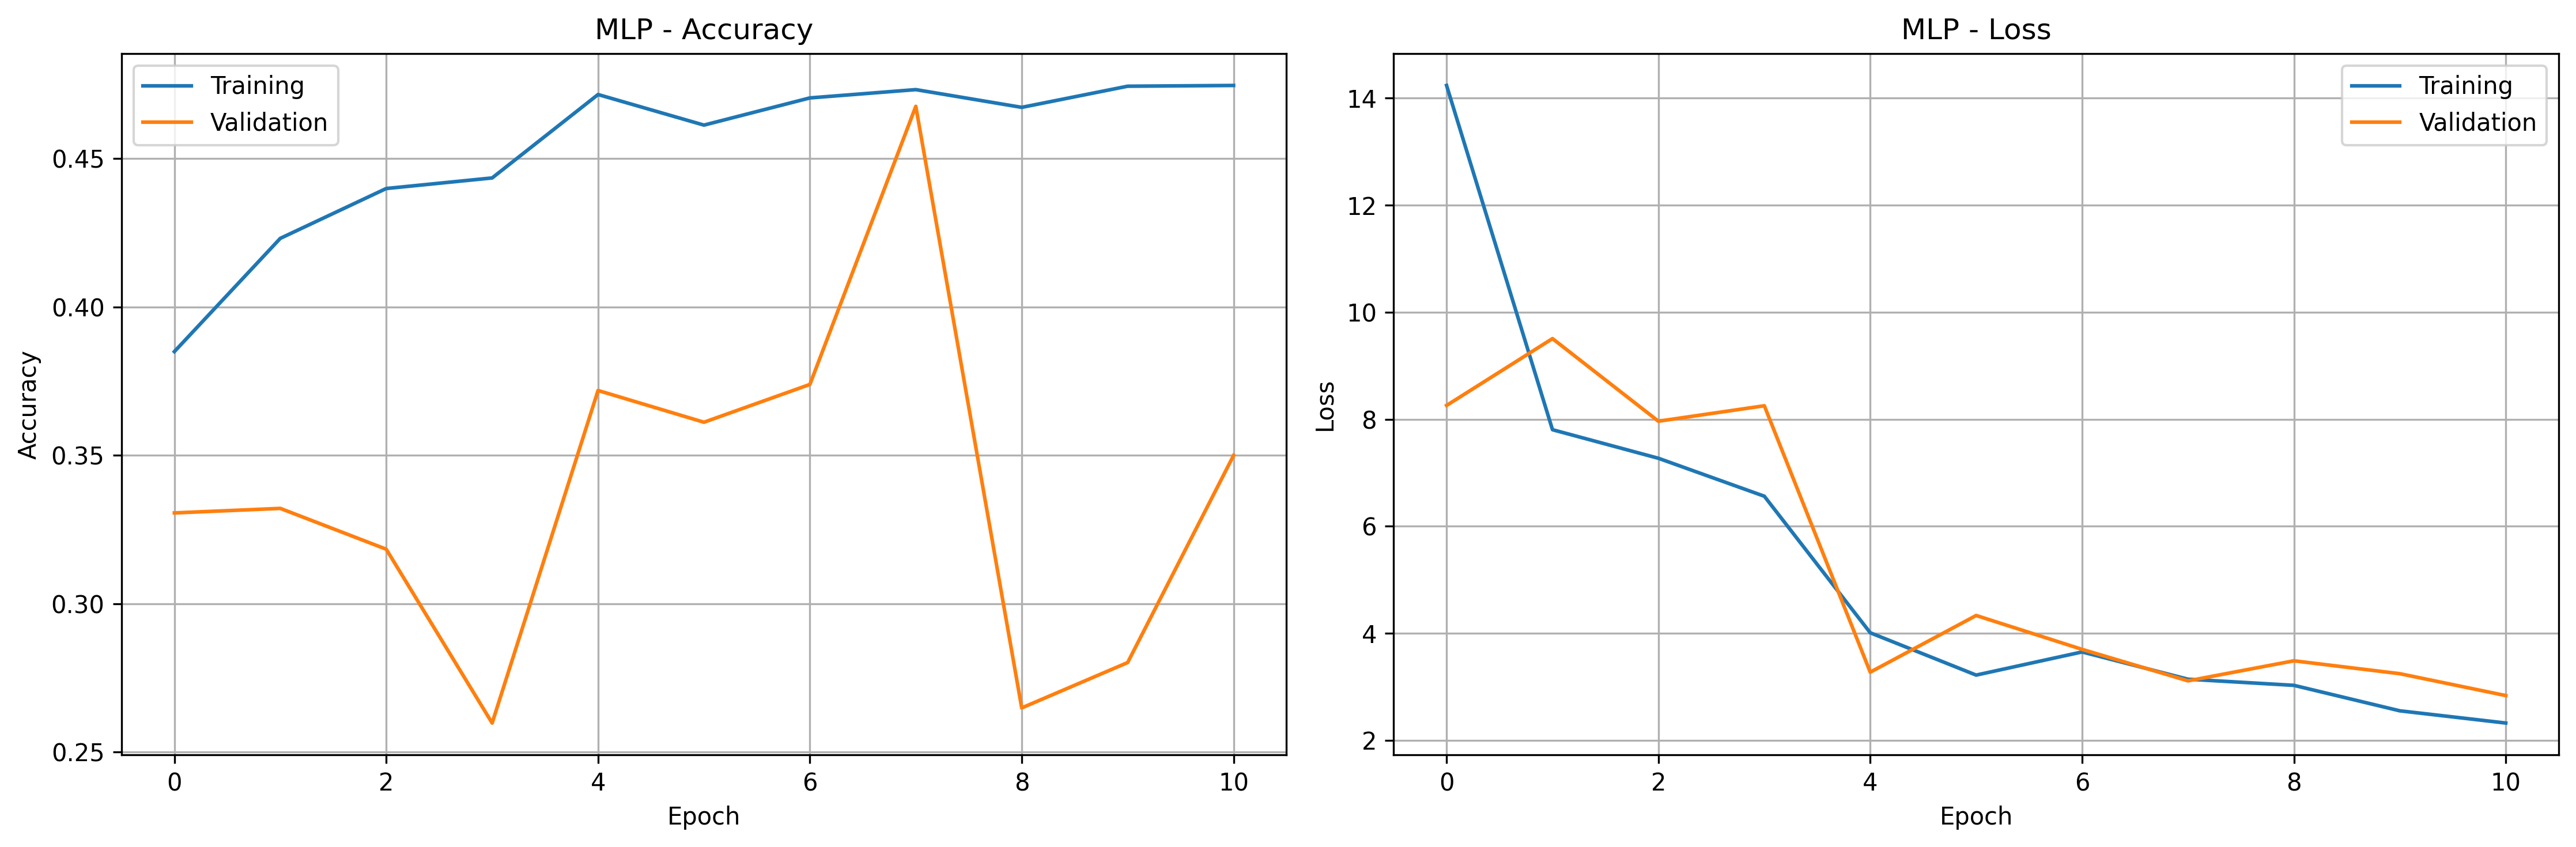

62/62 ━━━━━━━━━━━━━━━━━━━━ 54s 841ms/step

Classification Report for MLP:
                precision    recall  f1-score   support

Apple__Healthy       0.03      0.00      0.00       487
 Apple__Rotten       0.46      0.77      0.58       585
Guava__Healthy       0.00      0.00      0.00        40
 Guava__Rotten       0.00      0.00      0.00        40
Mango__Healthy       0.69      0.46      0.55       362
 Mango__Rotten       0.41      0.65      0.50       449

      accuracy                           0.46      1963
     macro avg       0.27      0.31      0.27      1963
  weighted avg       0.37      0.46      0.39      1963



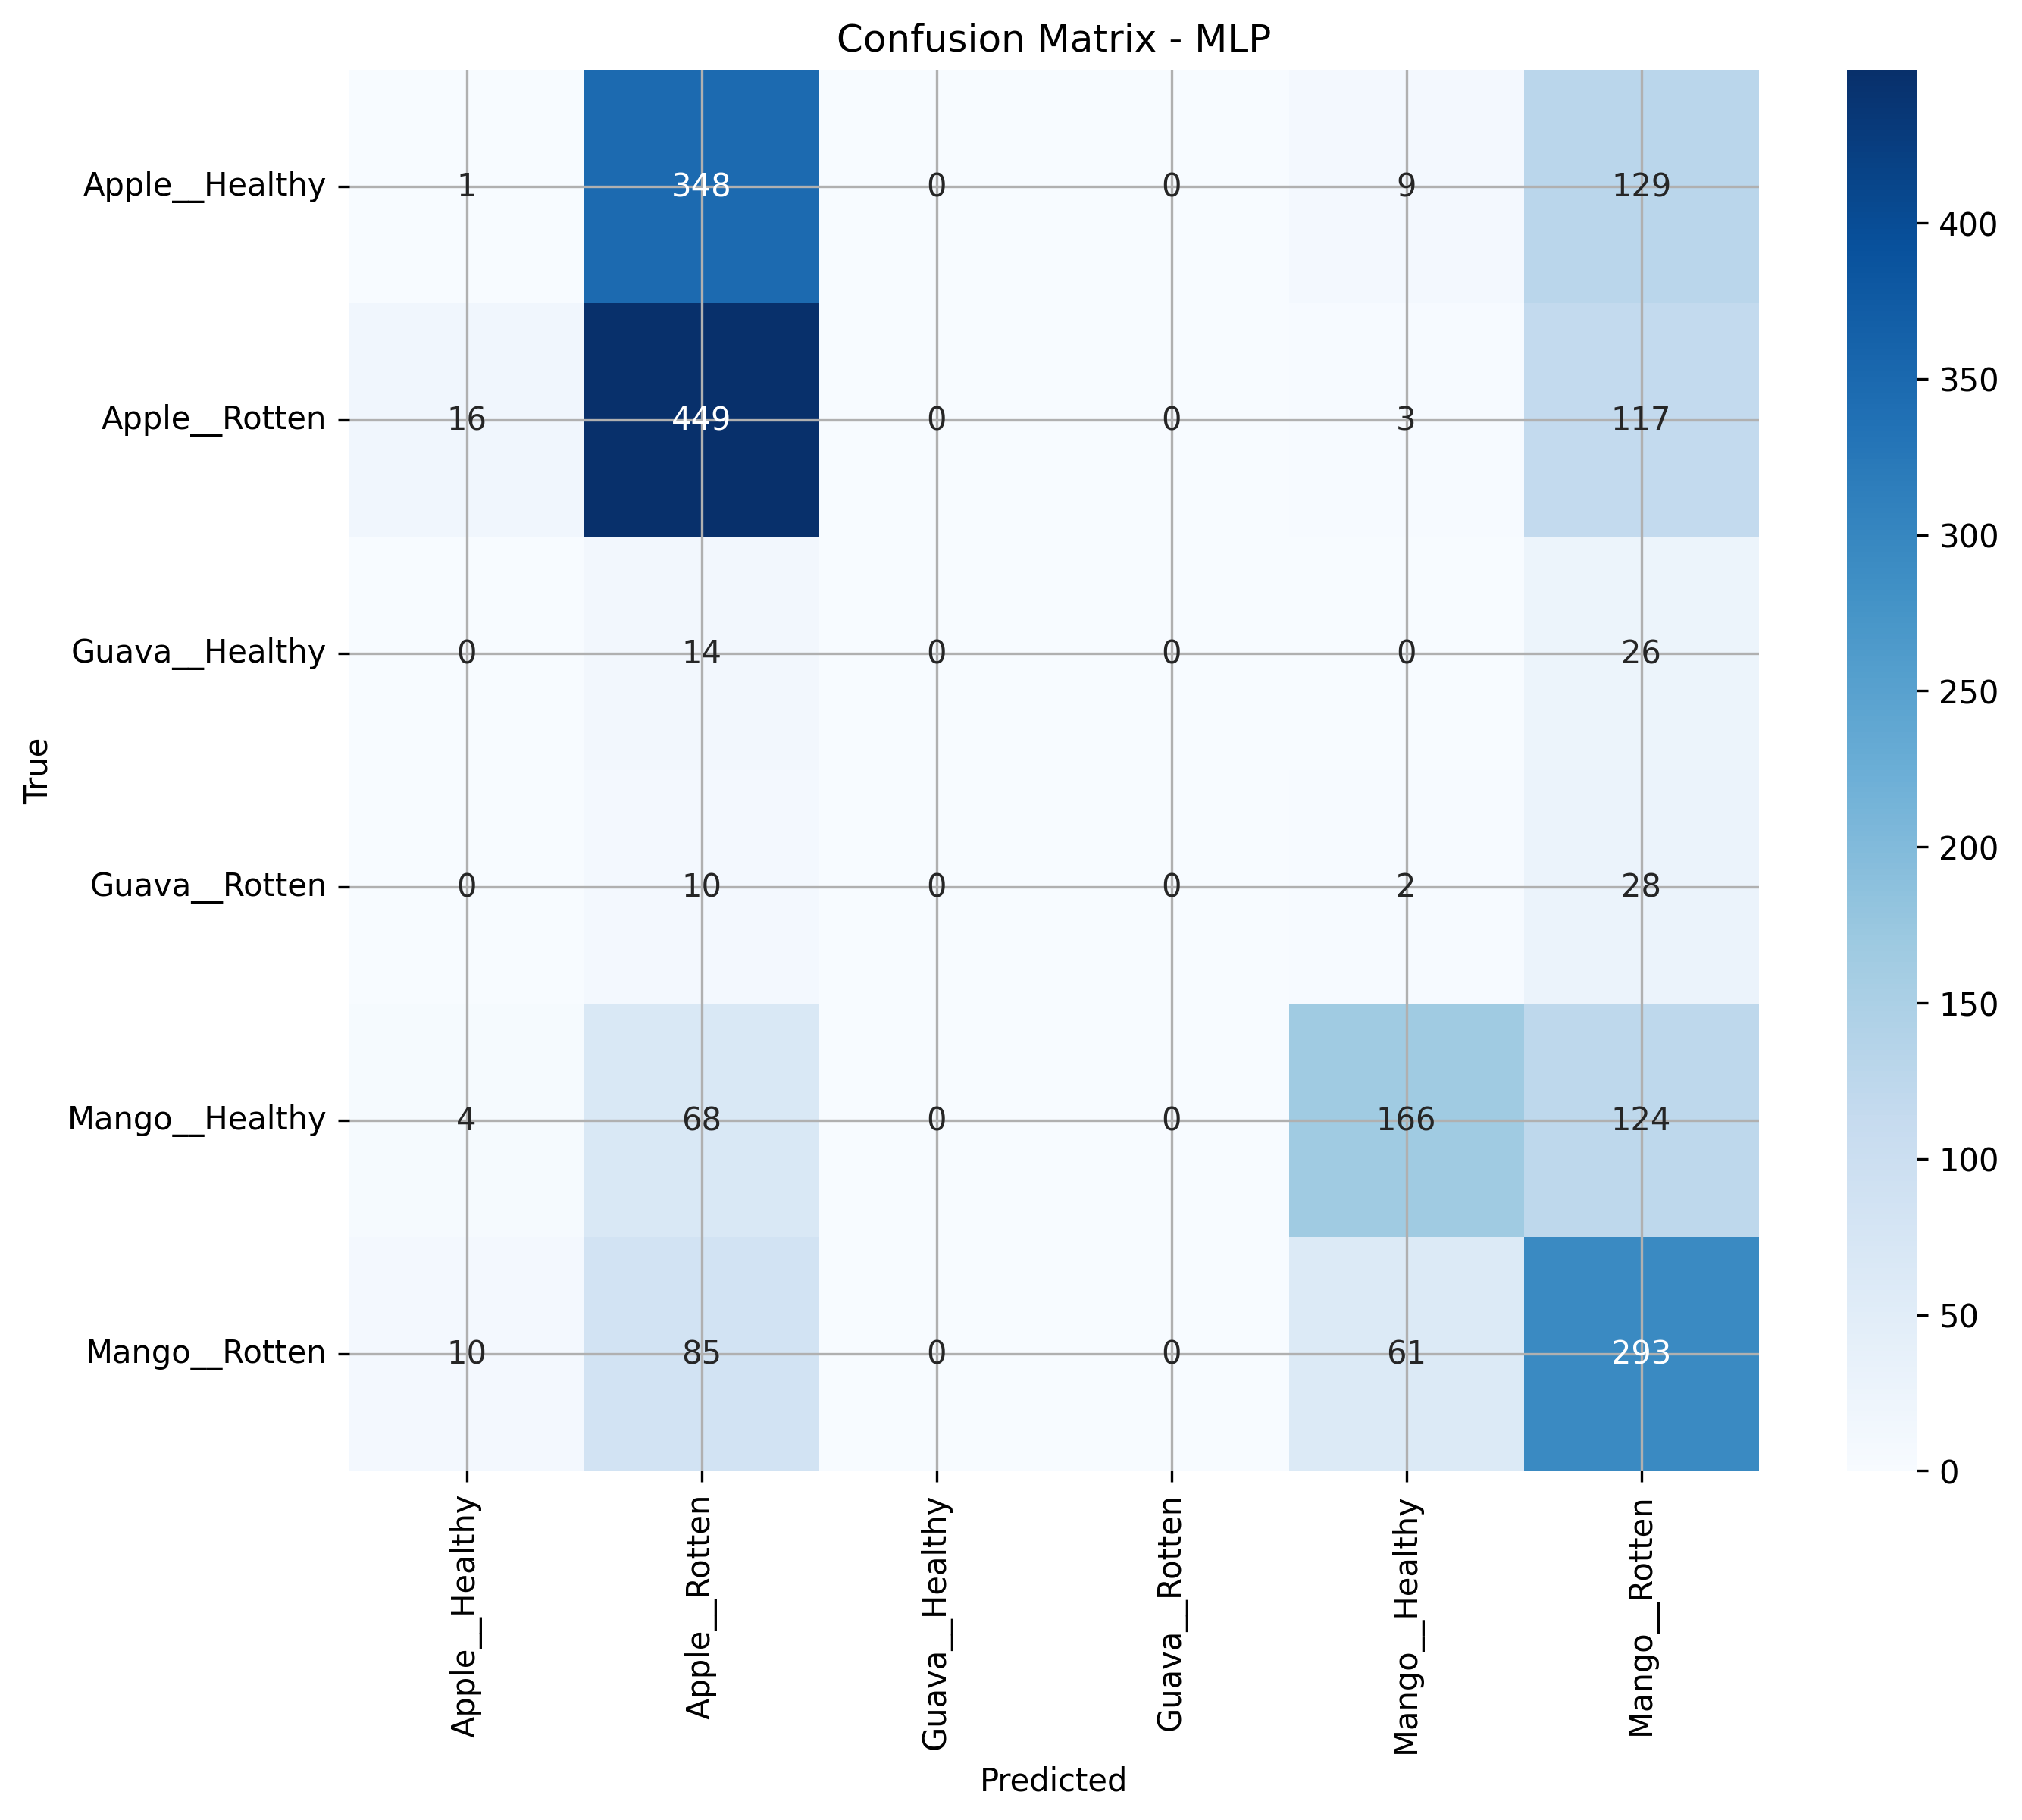


Training CNN...
Epoch 1/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 1609s 7s/step - accuracy: 0.5656 - loss: 14.5287 - val_accuracy: 0.1844 - val_loss: 6.8628 - learning_rate: 0.0010
Epoch 2/30
120/246 ━━━━━━━━━━━━━━━━━━━━ 13:29 6s/step - accuracy: 0.6859 - loss: 4.2191

In [ ]:

import datetime
import json

# Get the prepared generators
train_generator, validation_generator = data_prep.prepare_for_neural_networks()

# Train and evaluate MLP
print("Training MLP...")
mlp_model = create_mlp_model()
mlp_history = train_model(mlp_model, train_generator, validation_generator, 
                         'MLP', epochs=30)
plot_training_history(mlp_history, 'MLP')
evaluate_model(mlp_model, validation_generator, 'MLP')

# Train and evaluate CNN
print("\nTraining CNN...")
cnn_model = create_cnn_model()
cnn_history = train_model(cnn_model, train_generator, validation_generator, 
                         'CNN', epochs=30)
plot_training_history(cnn_history, 'CNN')
evaluate_model(cnn_model, validation_generator, 'CNN')

# Train and evaluate ResNet50V2
print("\nTraining Transfer Learning Model...")
transfer_model = create_transfer_model()
transfer_history = train_model(transfer_model, train_generator, validation_generator, 
                             'ResNet50V2', epochs=30)
plot_training_history(transfer_history, 'ResNet50V2')
evaluate_model(transfer_model, validation_generator, 'ResNet50V2')

# Compare all models
compare_models(
    [mlp_history, cnn_history, transfer_history],
    ['MLP', 'CNN', 'ResNet50V2']
)

# Save results
results = {
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'models': {
        'MLP': {
            'final_val_accuracy': float(mlp_history.history['val_accuracy'][-1]),
            'best_val_accuracy': float(max(mlp_history.history['val_accuracy'])),
            'final_val_loss': float(mlp_history.history['val_loss'][-1]),
            'epochs_trained': len(mlp_history.history['accuracy'])
        },
        'CNN': {
            'final_val_accuracy': float(cnn_history.history['val_accuracy'][-1]),
            'best_val_accuracy': float(max(cnn_history.history['val_accuracy'])),
            'final_val_loss': float(cnn_history.history['val_loss'][-1]),
            'epochs_trained': len(cnn_history.history['accuracy'])
        },
        'ResNet50V2': {
            'final_val_accuracy': float(transfer_history.history['val_accuracy'][-1]),
            'best_val_accuracy': float(max(transfer_history.history['val_accuracy'])),
            'final_val_loss': float(transfer_history.history['val_loss'][-1]),
            'epochs_trained': len(transfer_history.history['accuracy'])
        }
    }
}
with open('model_comparison_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("\nResults have been saved to 'model_comparison_results.json'")

The above trained models show poor results and doesnt shows complete output due to issues with my file being corrupted and having to re-implement certain parts in the end moment and didnt have enough time for the training to finish. In the reports appendix I will be attaching a comparison chart from a previous run. Also was not able to push the code earlier into github because I kept the image dataset as part of the files to push to git and it was too large, which I did not resolve until 22/11/2024. I will attach my local commit history using the git log command in the appendix of the report. 